# Dataset

* Read images
* Tile or resized image
* Data augmentation

In [1]:
import os
%pylab inline
from skimage.io import imread
from skimage.transform import resize
import numpy as np

Populating the interactive namespace from numpy and matplotlib


## Reading all images

In [2]:
directory = "D:/Adrien/dataset/GlaS/"
nTrainImages = 85

# Get all file names for training images & annotations
files_X = [os.path.join(directory, f'train/train_{i}.bmp') for i in range(1, nTrainImages+1)]
files_Y = [os.path.join(directory, f'train/train_{i}_anno.bmp') for i in range(1, nTrainImages+1)]

for x,y in zip(files_X, files_Y):
    print(x,y)
    break

D:/Adrien/dataset/GlaS/train/train_1.bmp D:/Adrien/dataset/GlaS/train/train_1_anno.bmp


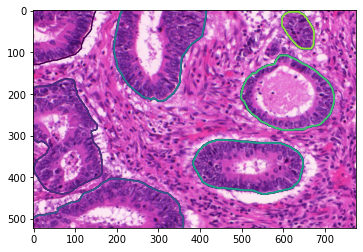

In [3]:
# Read all images
images_X = [imread(f) for f in files_X]
images_Y = [imread(f) for f in files_Y]

for x,y in zip(images_X, images_Y):
    plt.figure()
    plt.imshow(x)
    plt.contour(y)
    plt.show()
    break

## Option 1: resize images

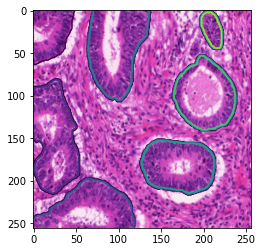

In [4]:
target_size = (256,256)
images_X_r = [resize(im, target_size) for im in images_X]
images_Y_r = [resize(im, target_size) for im in images_Y]

for x,y in zip(images_X_r, images_Y_r):
    plt.figure()
    plt.imshow(x)
    plt.contour(y)
    plt.show()
    break

Problem: resize does a rescaling to 0-1 & does some interpolation, so the labels are now incorrect:

In [5]:
print(f'There are now {len(np.unique(y))} unique labels')
print(np.unique(y))

There are now 1523 unique labels
[0.00000000e+00 6.28303079e-07 8.07818244e-07 ... 2.74460437e-02
 2.74468216e-02 2.74509804e-02]


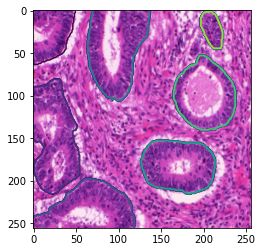

There are now 8 unique labels
[0. 1. 2. 3. 4. 5. 6. 7.]


In [6]:
target_size = (256,256)
images_X_r = [resize(im, target_size) for im in images_X]
images_Y_r = [resize(im, target_size, preserve_range=True, order=0, anti_aliasing=False) for im in images_Y]

for x,y in zip(images_X_r, images_Y_r):
    plt.figure()
    plt.imshow(x)
    plt.contour(y)
    plt.show()
    print(f'There are now {len(np.unique(y))} unique labels')
    print(np.unique(y))
    break

## Option 2: Tiling

For training: randomly select tile position

In [7]:
tile_size = (256,256)

im = images_X[0]
anno = images_Y[0]
pos = (np.random.randint(0, im.shape[0]-tile_size[0]), np.random.randint(0, im.shape[1]-tile_size[1]))
print(pos)

(148, 99)


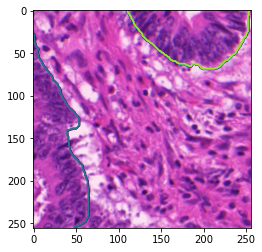

In [8]:
tile_x = im[pos[0]:pos[0]+tile_size[0], pos[1]:pos[1]+tile_size[1]]
tile_y = anno[pos[0]:pos[0]+tile_size[0], pos[1]:pos[1]+tile_size[1]]

plt.figure()
plt.imshow(tile_x)
plt.contour(tile_y)
plt.show()

For testing: regular tiling + stitching

In [9]:
# How many tiles fit in the image with minimum overlap?
import math
ny = math.ceil(im.shape[0]/tile_size[0])
nx = math.ceil(im.shape[1]/tile_size[1])

print(im.shape)
print(f'{ny}x{nx} tiles')

(522, 775, 3)
3x4 tiles


In [10]:
# Find tiles coordinates:
step_y = (im.shape[0]-tile_size[0])/(ny-1)
step_x = (im.shape[1]-tile_size[1])/(nx-1)
print(f'Move tiles by {step_y} pixels in y-dimension and {step_x} pixels in x-dimension')

Move tiles by 133.0 pixels in y-dimension and 173.0 pixels in x-dimension


In [11]:
# Check coordinates:
coords_y = np.arange(0, im.shape[0]-tile_size[0]+1, step_y).astype('int')
coords_x = np.arange(0, im.shape[1]-tile_size[1]+1, step_x).astype('int')
print(coords_y)
print(coords_y+tile_size[0])
print(coords_x)
print(coords_x+tile_size[1])

[  0 133 266]
[256 389 522]
[  0 173 346 519]
[256 429 602 775]


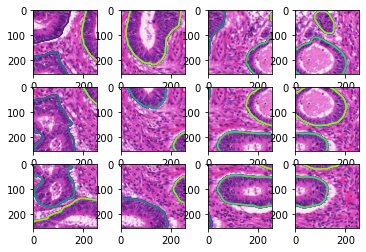

In [12]:
# Get tiles:
mesh = np.meshgrid(coords_x,coords_y)
tiles = zip(mesh[0].flatten(), mesh[1].flatten())

plt.figure('tiles')
for i,(tx,ty) in enumerate(tiles):
    plt.subplot(ny,nx,i+1,label='tiles')
    plt.imshow(im[ty:ty+tile_size[0],tx:tx+tile_size[1]])
    plt.contour(anno[ty:ty+tile_size[0],tx:tx+tile_size[1]])
plt.show()

Stitching on fake predictions using mean-averaging and max-averaging:

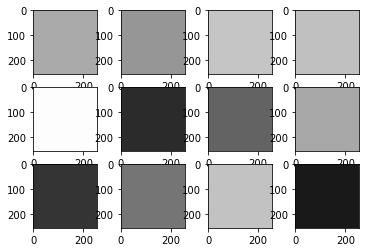

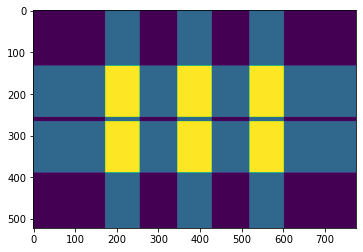

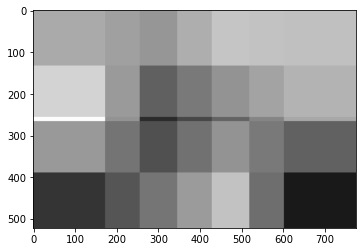

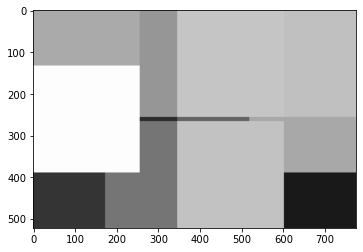

In [13]:
pred_image_mean = np.zeros_like(anno).astype('float')
pred_image_max = np.zeros_like(anno).astype('float')
n_preds = np.zeros_like(anno) # to keep track of how many predictions were made on a given pixel

tiles = zip(mesh[0].flatten(), mesh[1].flatten())
plt.figure()
for i,(tx,ty) in enumerate(tiles):
    pred = np.ones_like(anno[ty:ty+tile_size[0],tx:tx+tile_size[1]])*np.random.random()
    pred_image_mean[ty:ty+tile_size[0],tx:tx+tile_size[1]] += pred
    n_preds[ty:ty+tile_size[0],tx:tx+tile_size[1]] += 1
    pred_image_max[ty:ty+tile_size[0],tx:tx+tile_size[1]] = np.maximum(pred_image_max[ty:ty+tile_size[0],tx:tx+tile_size[1]], pred)
    plt.subplot(ny,nx,i+1)
    plt.imshow(pred, vmin=0, vmax=1, cmap=plt.cm.gray)
plt.show()

pred_image_mean /= n_preds

plt.figure()
plt.imshow(n_preds)
plt.figure()
plt.imshow(pred_image_mean, vmin=0, vmax=1, cmap=plt.cm.gray)
plt.figure()
plt.imshow(pred_image_max, vmin=0, vmax=1, cmap=plt.cm.gray)
plt.show()

Using a "weighted" average:

0.0 1.0


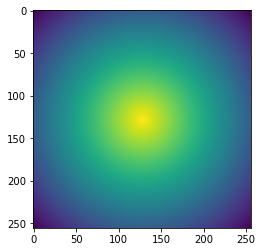

In [52]:
from scipy.ndimage import distance_transform_edt

weights = np.ones(tile_size)
weights[tile_size[0]//2, tile_size[1]//2] = 0
weights = distance_transform_edt(weights)
weights /= weights.max()
weights = 1-weights
print(weights.min(), weights.max())
plt.figure()
plt.imshow(weights)
plt.show()

(522, 775, 3)
16x20 tiles
Move tiles by 17.733333333333334 pixels in y-dimension and 27.31578947368421 pixels in x-dimension
522
775


C:\Users\8Utilisateur\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


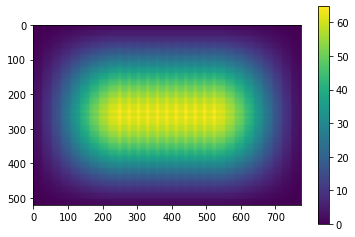

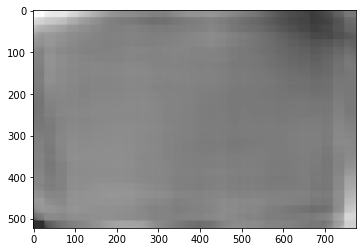

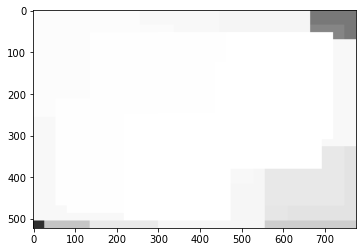

In [53]:
# Using a lot more overlap & weighted averaging
ny = 16
nx = 20

print(im.shape)
print(f'{ny}x{nx} tiles')

# Find tiles coordinates:
step_y = (im.shape[0]-tile_size[0])/(ny-1)
step_x = (im.shape[1]-tile_size[1])/(nx-1)
print(f'Move tiles by {step_y} pixels in y-dimension and {step_x} pixels in x-dimension')

# Check coordinates:
coords_y = np.arange(0, im.shape[0]-tile_size[0]+1, step_y).astype('int')
coords_x = np.arange(0, im.shape[1]-tile_size[1]+1, step_x).astype('int')
print((coords_y+tile_size[0])[-1])
print((coords_x+tile_size[1])[-1])

# Get tiles:
mesh = np.meshgrid(coords_x,coords_y)
tiles = zip(mesh[0].flatten(), mesh[1].flatten())

pred_image_mean = np.zeros_like(anno).astype('float')
pred_image_max = np.zeros_like(anno).astype('float')
n_preds = np.zeros_like(anno).astype('float') # to keep track of how many predictions were made on a given pixel

tiles = zip(mesh[0].flatten(), mesh[1].flatten())
for i,(tx,ty) in enumerate(tiles):
    pred = np.ones_like(anno[ty:ty+tile_size[0],tx:tx+tile_size[1]])*np.random.random()
    pred_image_mean[ty:ty+tile_size[0],tx:tx+tile_size[1]] += pred*weights
    n_preds[ty:ty+tile_size[0],tx:tx+tile_size[1]] += weights
    pred_image_max[ty:ty+tile_size[0],tx:tx+tile_size[1]] = np.maximum(pred_image_max[ty:ty+tile_size[0],tx:tx+tile_size[1]], pred)
    
pred_image_mean /= n_preds

plt.figure()
plt.imshow(n_preds)
plt.colorbar()
plt.figure()
plt.imshow(pred_image_mean, vmin=0, vmax=1, cmap=plt.cm.gray)
plt.figure()
plt.imshow(pred_image_max, vmin=0, vmax=1, cmap=plt.cm.gray)
plt.show()

## Random sampling

* For whole images: each batch will contain N images, image order is shuffled at each epoch
 * 1 epoch = n_images//batch_size steps
* For tiled images: each batch will contain N randomly selected tiles in an image, image order is shuffled at each epoch.
 * 1 epoch = n_images steps

### Whole images

In [75]:
idxs = np.arange(len(images_X))
n_epochs = 5
batch_size = 10
batches_per_epoch = len(idxs)//batch_size
print(f'Starting {n_epochs} epochs with {batches_per_epoch} batches per epoch')
for e in range(n_epochs):
    np.random.shuffle(idxs)
    print(f'Epoch {e} with order: {idxs}')
    for b in range(batches_per_epoch):
        batch_x = np.array([images_X_r[idx] for idx in idxs[b*batch_size:(b+1)*batch_size]])
        batch_y = np.array([images_Y_r[idx] for idx in idxs[b*batch_size:(b+1)*batch_size]])
        print(f'Batch contains: {idxs[b*batch_size:(b+1)*batch_size]}')

Starting 5 epochs with 8 batches per epoch
Epoch 0 with order: [14 29  5 78 63 51 25 39 77 54 81  1 13 83 60  0  8 46 16 48 36  7 68 55
  3 79 26 33 21 72 61 74 58 10 64 80 20 44 71  4 43 17 11 22 23 45 37 65
 47 32 73 50 76 75 42 19 34 84 70 38 24 66 62 69  2  9 57  6 67 15 82 53
 18 56 28 12 27 59 41 49 52 31 40 30 35]
Batch contains: [14 29  5 78 63 51 25 39 77 54]
Batch contains: [81  1 13 83 60  0  8 46 16 48]
Batch contains: [36  7 68 55  3 79 26 33 21 72]
Batch contains: [61 74 58 10 64 80 20 44 71  4]
Batch contains: [43 17 11 22 23 45 37 65 47 32]
Batch contains: [73 50 76 75 42 19 34 84 70 38]
Batch contains: [24 66 62 69  2  9 57  6 67 15]
Batch contains: [82 53 18 56 28 12 27 59 41 49]
Epoch 1 with order: [ 8 19 59 49 12 84 21 45 17  7 24 51 82 62  3 52 77 33 41 57 39 10 20 58
 34 14 16 54 55 63 47 23 53 28 40 65 83 67 56 69 26 13 76 25 64 72 11  4
 71  9 50 30  5 35 61 81 48 43 70 31 66 74 73 42  6 38  1 68  2 79 37 75
 27 36 44 80 78 60 15 22 18  0 32 29 46]
Batch contain

### Tiles

In [78]:
idxs = np.arange(len(images_X))
n_epochs = 5
batch_size = 10
batches_per_epoch = len(idxs)
print(f'Starting {n_epochs} epochs with {batches_per_epoch} batches per epoch')
for e in range(n_epochs):
    np.random.shuffle(idxs)
    print(f'Epoch {e} with order: {idxs}')
    for idx in idxs:
        im = images_X[idx]
        anno = images_Y[idx]
        pos_y = np.random.randint(0, im.shape[0]-tile_size[0], size=(batch_size,))
        pos_x = np.random.randint(0, im.shape[1]-tile_size[1], size=(batch_size,))

        batch_x = np.zeros((batch_size,)+tile_size+(3,))
        batch_y = np.zeros((batch_size,)+tile_size)
        for i,pos in enumerate(zip(pos_y,pos_x)):
            batch_x[i] = im[pos[0]:pos[0]+tile_size[0], pos[1]:pos[1]+tile_size[1]]
            batch_y[i] = anno[pos[0]:pos[0]+tile_size[0], pos[1]:pos[1]+tile_size[1]]
        
        print(f'Tiles sampled from image {idx}')

Starting 5 epochs with 85 batches per epoch
Epoch 0 with order: [15  5 70  6 61 54 72 10 47 37 67 42  1 69 60 82 31 16 45 46 12 62 11  3
 53 78 73 68 52 27 43 65 74 21 64 55 19 13 18 14  7  0 80 51 59  8 49  4
 35 48 58 20  2 81 76 26 83 32 63 34 50 57 36 30 41 44 24  9 29 75 25 38
 77 84 39 28 33 71 79 23 56 40 17 66 22]
Tiles sampled from image 15
Tiles sampled from image 5
Tiles sampled from image 70
Tiles sampled from image 6
Tiles sampled from image 61
Tiles sampled from image 54
Tiles sampled from image 72
Tiles sampled from image 10
Tiles sampled from image 47
Tiles sampled from image 37
Tiles sampled from image 67
Tiles sampled from image 42
Tiles sampled from image 1
Tiles sampled from image 69
Tiles sampled from image 60
Tiles sampled from image 82
Tiles sampled from image 31
Tiles sampled from image 16
Tiles sampled from image 45
Tiles sampled from image 46
Tiles sampled from image 12
Tiles sampled from image 62
Tiles sampled from image 11
Tiles sampled from image 3
Tiles sa

Tiles sampled from image 63
Tiles sampled from image 6
Tiles sampled from image 81
Tiles sampled from image 59
Tiles sampled from image 68
Tiles sampled from image 31
Tiles sampled from image 21
Tiles sampled from image 76
Tiles sampled from image 84
Tiles sampled from image 1
Tiles sampled from image 40
Tiles sampled from image 55
Tiles sampled from image 15
Tiles sampled from image 36
Tiles sampled from image 75
Tiles sampled from image 73
Tiles sampled from image 72
Tiles sampled from image 4
Tiles sampled from image 70
Tiles sampled from image 0
Tiles sampled from image 69
Tiles sampled from image 28
Tiles sampled from image 20
Tiles sampled from image 33
Tiles sampled from image 5
Tiles sampled from image 45
Tiles sampled from image 37
Tiles sampled from image 60
Tiles sampled from image 52
Tiles sampled from image 29
Tiles sampled from image 77
Tiles sampled from image 14
Tiles sampled from image 48
Tiles sampled from image 25
Tiles sampled from image 3
Tiles sampled from image 3

# Data augmentation 

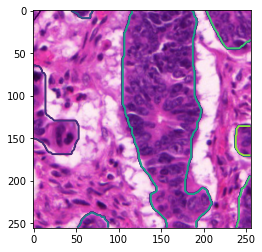

In [80]:
# example on one image from last batch:
plt.figure()
plt.imshow(batch_x[0]/255)
plt.contour(batch_y[0])
plt.show()

Mirrors:

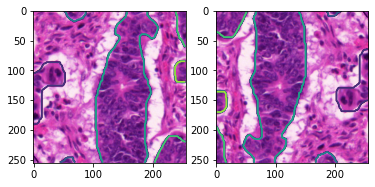

In [82]:
flip_ver_x = batch_x[0,::-1,:,:]
flip_ver_y = batch_y[0,::-1,:]
flip_hor_x = batch_x[0,:,::-1,:]
flip_hor_y = batch_y[0,:,::-1]
plt.figure()
plt.subplot(1,2,1)
plt.imshow(flip_ver_x/255)
plt.contour(flip_ver_y)
plt.subplot(1,2,2)
plt.imshow(flip_hor_x/255)
plt.contour(flip_hor_y)
plt.show()

Random noise:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


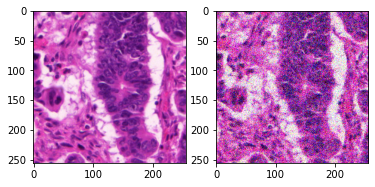

In [91]:
noise_std = 0.2
noise = np.random.normal(0, noise_std, size=batch_x[0].shape)
noise_x = batch_x[0]/255+noise

plt.figure()
plt.subplot(1,2,1)
plt.imshow(batch_x[0]/255)
plt.subplot(1,2,2)
plt.imshow(noise_x)
plt.show()

Random gamma correction:

0.8688543950730775


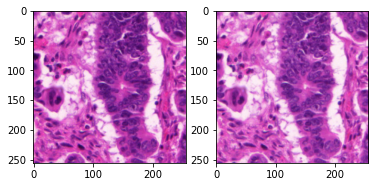

In [146]:
from skimage import exposure

gamma = (np.random.random()-0.5)*2
if gamma < 0:
    print(1/(1-gamma))
    gamma_x = exposure.adjust_gamma(batch_x[0]/255, gamma=1/(1-gamma))
else:
    print(1+gamma)
    gamma_x = exposure.adjust_gamma(batch_x[0]/255, gamma=1+gamma)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(batch_x[0]/255)
plt.subplot(1,2,2)
plt.imshow(gamma_x)
plt.show()